In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from collections import defaultdict
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import string

In [2]:
dataset = pd.read_pickle("renttherunway_data_processed.pkl")

In [3]:
dataset = dataset.dropna()
dataset = dataset.drop(dataset[dataset['rented for']== "party: cocktail"].index)

# 0 = Small, 1 = Fit, 2 = Large
dataset.loc[dataset["fit"] == "small", "fit"] = 1

dataset.loc[dataset["fit"] == "fit", "fit"] = 0

dataset.loc[dataset["fit"] == "large", "fit"] = 2

In [75]:
data = pd.DataFrame(dataset).to_dict('record')

for d in data:
    d['weight'] = int(d['weight'])#.split('lbs')[0])
    d['height'] = int(d['height'])#.split(' ')[0][:-1])*12 + int(d['height'].split(' ')[1][:-1])

catogeries = ['rented for','body type']
for cat in catogeries:
    categories_list = defaultdict(int)
    for d in data:
        categories_list[d[cat]] += 1
        
    categories_id = defaultdict(int)

    i = 0
    for cID in  categories_list:
        categories_id[cID] = i
        i+=1
    for d in data:
        f = [0]*len(categories_list)
        f[categories_id[d[cat]]] = 1
        d[cat] = f[:len(categories_list)-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  """Entry point for launching an IPython kernel.


In [76]:
embeddings_dict = {}
with open("glove.6B.100d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [77]:
def get_word_embeddings(word):
    try:
        return embeddings_dict[word]
    except KeyError:
        return np.zeros(100)

In [78]:
punctuation = set(string.punctuation)
type(embeddings_dict['the'])

numpy.ndarray

In [79]:
stop_words=["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]

In [80]:
df = []
for d in data:
    arr = []
    arr.append(d['rating'])
    arr += d['rented for']
    # if sum([get_word_embeddings(word) for word in d['review_text'].split() if word not in stop_words]) ==0:
      # continue
    #break
    try:
      arr += list(sum([get_word_embeddings(word) for word in d['review_text'].split() if word not in stop_words])/len([get_word_embeddings(word) for word in d['review_text'].split() if word not in stop_words]))
    except:
      arr += [0]*100
    
    try:
        arr += list(sum([get_word_embeddings(word) for word in d['review_summary'].split() if word not in stop_words])/(len([get_word_embeddings(word) for word in d['review_summary'].split() if word not in stop_words])+1))
    except:
        arr += [0]*100
    arr += d['body type']
    arr.append(d['size'])
    df.append(arr)

In [81]:
len(df[1])

215

In [82]:
y = dataset["fit"]
y_cat = to_categorical(y)
split_ratio = .85
test_y = y_cat[int(len(y_cat) * split_ratio):]
train_y = y_cat[:int(len(y_cat) * split_ratio)]
test_f = df[int(len(y_cat) * split_ratio):]
train_f = df[:int(len(y_cat) * split_ratio)]
test_f = np.array(test_f)
train_f = np.array(train_f)

In [83]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [84]:
model = Sequential()
model.add(Dense(60, input_shape = (len(train_f[0]), ), activation = "relu"))
model.add(Dense(40, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(3, activation = "softmax"))
model.compile(Adam(lr = 0.001), "categorical_crossentropy", metrics = ['acc',f1_m,precision_m, recall_m])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 60)                12960     
                                                                 
 dense_16 (Dense)            (None, 40)                2440      
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_17 (Dense)            (None, 3)                 123       
                                                                 
Total params: 15,523
Trainable params: 15,523
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [85]:
model_history=model.fit(train_f, train_y, verbose=1, epochs=20)

Epoch 1/20
4387/4387 [==============================] - 11s 2ms/step - loss: 0.6778 - acc: 0.7453 - f1_m: 0.7378 - precision_m: 0.7752 - recall_m: 0.7055
Epoch 2/20
4387/4387 [==============================] - 11s 3ms/step - loss: 0.6506 - acc: 0.7548 - f1_m: 0.7481 - precision_m: 0.7838 - recall_m: 0.7167
Epoch 3/20
4387/4387 [==============================] - 10s 2ms/step - loss: 0.6428 - acc: 0.7576 - f1_m: 0.7523 - precision_m: 0.7852 - recall_m: 0.7230
Epoch 4/20
4387/4387 [==============================] - 10s 2ms/step - loss: 0.6371 - acc: 0.7600 - f1_m: 0.7537 - precision_m: 0.7854 - recall_m: 0.7255
Epoch 5/20
4387/4387 [==============================] - 10s 2ms/step - loss: 0.6331 - acc: 0.7620 - f1_m: 0.7561 - precision_m: 0.7863 - recall_m: 0.7291
Epoch 6/20
4387/4387 [==============================] - 10s 2ms/step - loss: 0.6296 - acc: 0.7626 - f1_m: 0.7568 - precision_m: 0.7863 - recall_m: 0.7305
Epoch 7/20
4387/4387 [==============================] - 10s 2ms/step - loss:

In [86]:
predict_x=model.predict(test_f) 
y_pred_class=np.argmax(predict_x,axis=1)

775/775 [==============================] - 1s 1ms/step


In [87]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(test_f)
y_test_class = np.argmax(test_y, axis=1)
confusion_matrix(y_test_class, y_pred_class)

775/775 [==============================] - 1s 1ms/step


array([[17731,   328,   184],
       [ 2576,   639,   114],
       [ 2563,   149,   486]])

In [88]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_class, y_pred_class).round(4)

0.7612

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


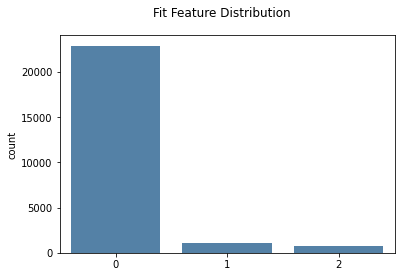

In [89]:
import seaborn as sns
fig = sns.countplot(y_pred_class, color='steelblue').get_figure()
fig.suptitle("Fit Feature Distribution")
fig.savefig("fit_statistics.png")

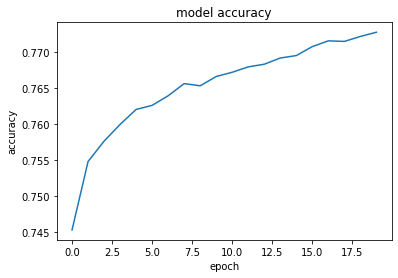

In [90]:
acc_curve=sns.lineplot(y=model_history.history['acc'],x=range(0,20))
acc_curve.set(xlabel ="epoch", ylabel = "accuracy", title ='model accuracy')
acc_curve.figure.savefig("accuracy_curve.png")

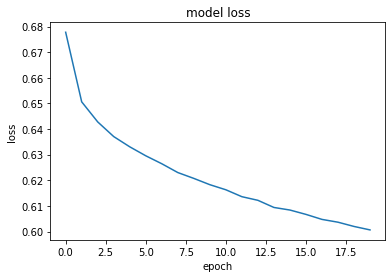

In [91]:
loss_curve=sns.lineplot(y=model_history.history['loss'],x=range(0,20))
loss_curve.set(xlabel ="epoch", ylabel = "loss", title ='model loss')
loss_curve.figure.savefig("loss_curve.png")

In [62]:
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [63]:
def get_word_embeddings(word):
    try:
        return embeddings_dict[word]
    except KeyError:
        return np.zeros(50)

In [64]:
df = []
for d in data:
    arr = []
#     arr.append(d['weight'])
    arr.append(d['rating'])
    arr += d['rented for']
    # if sum([get_word_embeddings(word) for word in d['review_text'].split() if word not in stop_words]) ==0:
      # continue
    #break
    try:
      arr += list(sum([get_word_embeddings(word) for word in d['review_text'].split() if word not in stop_words])/len([get_word_embeddings(word) for word in d['review_text'].split() if word not in stop_words]))
    except:
      arr += [0]*50
    
    try:
        arr += list(sum([get_word_embeddings(word) for word in d['review_summary'].split() if word not in stop_words])/(len([get_word_embeddings(word) for word in d['review_summary'].split() if word not in stop_words])+1))
    except:
        arr += [0]*50
    arr += d['body type']
    arr.append(d['size'])
    df.append(arr)

In [65]:
y = dataset["fit"]
y_cat = to_categorical(y)
split_ratio = .85
test_y = y_cat[int(len(y_cat) * split_ratio):]
train_y = y_cat[:int(len(y_cat) * split_ratio)]
test_f = df[int(len(y_cat) * split_ratio):]
train_f = df[:int(len(y_cat) * split_ratio)]
test_f = np.array(test_f)
train_f = np.array(train_f)

In [66]:
model = Sequential()
model.add(Dense(60, input_shape = (len(train_f[0]), ), activation = "relu"))
model.add(Dense(40, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(3, activation = "softmax"))
model.compile(Adam(lr = 0.001), "categorical_crossentropy", metrics = ['acc',f1_m,precision_m, recall_m])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 60)                6960      
                                                                 
 dense_13 (Dense)            (None, 40)                2440      
                                                                 
 dropout_4 (Dropout)         (None, 40)                0         
                                                                 
 dense_14 (Dense)            (None, 3)                 123       
                                                                 
Total params: 9,523
Trainable params: 9,523
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [67]:
model_history=model.fit(train_f, train_y, verbose=1, epochs=20)

Epoch 1/20
4387/4387 [==============================] - 10s 2ms/step - loss: 0.6972 - acc: 0.7411 - f1_m: 0.7359 - precision_m: 0.7618 - recall_m: 0.7127
Epoch 2/20
4387/4387 [==============================] - 9s 2ms/step - loss: 0.6796 - acc: 0.7456 - f1_m: 0.7405 - precision_m: 0.7690 - recall_m: 0.7150
Epoch 3/20
4387/4387 [==============================] - 10s 2ms/step - loss: 0.6735 - acc: 0.7474 - f1_m: 0.7424 - precision_m: 0.7696 - recall_m: 0.7180
Epoch 4/20
4387/4387 [==============================] - 9s 2ms/step - loss: 0.6701 - acc: 0.7493 - f1_m: 0.7445 - precision_m: 0.7704 - recall_m: 0.7212
Epoch 5/20
4387/4387 [==============================] - 9s 2ms/step - loss: 0.6659 - acc: 0.7497 - f1_m: 0.7450 - precision_m: 0.7710 - recall_m: 0.7215
Epoch 6/20
4387/4387 [==============================] - 10s 2ms/step - loss: 0.6632 - acc: 0.7508 - f1_m: 0.7460 - precision_m: 0.7726 - recall_m: 0.7221
Epoch 7/20
4387/4387 [==============================] - 9s 2ms/step - loss: 0.6

In [68]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(test_f)
y_test_class = np.argmax(test_y, axis=1)
confusion_matrix(y_test_class, y_pred_class)

775/775 [==============================] - 1s 1ms/step


array([[17650,   313,   280],
       [ 2508,   665,   156],
       [ 2453,   162,   583]])

In [69]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_class, y_pred_class).round(4)

0.7629

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


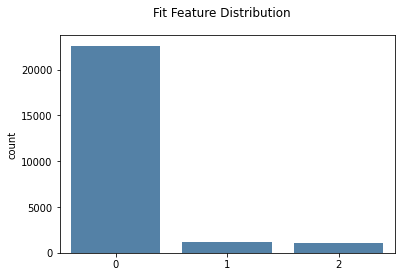

In [70]:
import seaborn as sns
fig = sns.countplot(y_pred_class, color='steelblue').get_figure()
fig.suptitle("Fit Feature Distribution")
fig.savefig("fit_statistics.png")

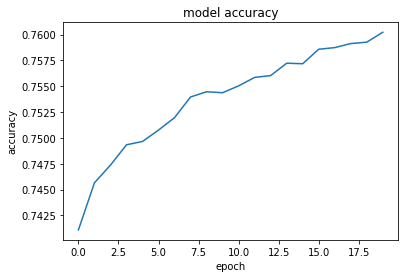

In [73]:
acc_curve=sns.lineplot(y=model_history.history['acc'],x=range(0,20))
acc_curve.set(xlabel ="epoch", ylabel = "accuracy", title ='model accuracy')
acc_curve.figure.savefig("accuracy_curve.png")

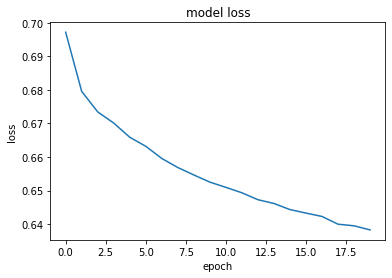

In [74]:
loss_curve=sns.lineplot(y=model_history.history['loss'],x=range(0,20))
loss_curve.set(xlabel ="epoch", ylabel = "loss", title ='model loss')
loss_curve.figure.savefig("loss_curve.png")